In [ ]:
#default_exp lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Light Curve Generation
> Generate light curves from cells

A "light curve" is a table indexed by time, 't', in MJD with columns

- tw -- the cell width, initialized to be config.time_interval: when cells are combined
- n  -- number of photons
- fexp -- relative exposure
- fit -- the fit object, containing info about the flux. This is usually a `PoissonRep` object



In [ ]:
#export
import numpy as np
import pylab as plt
import pandas as pd

In [ ]:
#export
from light_curves.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable)

class _LightCurve(object):
    """ Apply likelihood fits to a set of cells
    
    parameters:
       - cells : a table with index t, columns  tw, n, fexp, w, S, B
       - min_exp : minimum fractional exposure allowed
       - rep_name : represention to use 

    Generates a DataTable with columns n, fexp, fit
        
    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config, 
                all_cells, 
                source, 
                min_exp:  'minimum exposure factor'= 0.3,
                rep_name: 'likelihood rep name'='',
    
                ):
        """Apply fits to the likelihoods for a set of cells
        
 
        """

        self.source_name = source.name
 

        # select the set of cells
        cells = all_cells.query(f'fexp>{min_exp}').copy()
        
        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
        if config.verbose>0:
            print(f'Loaded {len(cells)} / {len(all_cells)} cells with exposure >'\
                  f' {min_exp} for light curve analysis')

        # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')
        
        # making output with reduced columns 
        self.ll_fits = cells['t n fexp'.split()].copy()
        self.ll_fits.loc[:,'tw'] = config.time_interval
        self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'


    @property
    def dataframe(self):
        """return the DataFrame
        """
        return self.ll_fits

In [ ]:
#export    

from light_curves.config import Config, Files, PointSource
from light_curves.cells import get_cells

def get_lightcurve(config, files, source, bin_edges=None):
    """Returns a lightcurve table for the source
    
    """
    def doit():
        all_cells = get_cells(config, files, source, bin_edges)
        lc = _LightCurve(config, all_cells, source).dataframe
        return lc
        
    if bin_edges is None:
        key = f'lightcurve_{source.name}'
        # use cache only for full data set
        if config.verbose>1: 
            print(f'using cache with key "{key}", exists: {key in files.cache}')
        return files.cache(key, doit)
    
    return doit()


    

In [ ]:
#collapse_hide
from light_curves.config import Config, Files, PointSource
from light_curves.cells import get_cells

config = Config()
files = Files()
source = PointSource('Geminga')
if files.valid:
    print(f'Loading cells with source {source.name} ')
    lc = get_lightcurve(config, files, source)
    assert lc is not None
    
else:
    print('Not testing since no files.')
    lc = None
if lc is not None:
    c = lc.iloc[0]
    print(f'\nFirst cell contents:\n{c}')
    print(f'\nFirst cell fit: {c["fit"]}')

Loading cells with source Geminga 
using cache with key "lightcurve_Geminga", exists: True

First cell contents:
t                                                 54683.5
n                                                     330
fexp                                              1.26456
tw                                                      1
fit     light_curves.loglike.PoissonRep: flux: 0.927[1...
Name: 0, dtype: object

First cell fit: light_curves.loglike.PoissonRep: flux: 0.927[1+0.076-0.079], limit: 1.05, ts: 481.8


In [ ]:
#export
def flux_plot(config, lightcurve, ts_min=9,  title=None, ax=None, fignum=1,
              figsize=(12,4),
              colors=('cornflowerblue','sandybrown'), fmt=' ',
              **kwargs): 
    """Make a plot of flux vs. MJD
    
    - lightcurve 
    - ts_min -- threshold for ploting limit
    - colors -- tuple of colors for signal, limit
    - kwargs -- apply to the Axis object
    
    returns the Figure instance
    """
    kw=dict(yscale='linear',xlabel='MJD', ylabel='relative flux')
    kw.update(**kwargs)
    df=lightcurve
    rep = config.likelihood_rep
    if rep =='poisson':
        ts = df.fit.apply(lambda f: f.ts) 
        limit = ts<ts_min
        bar = df.loc[~limit,:]
        lim = df.loc[limit,:]
    else: 
        bar=df; lim=[]

    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)\
        if ax is not None else (ax.figure,ax)

    # the points with error bars
    t = bar.t
    tw = bar.tw if 'tw' in bar.columns else np.full(len(t), config.time_interval) 
    flux =  bar.fit.apply(lambda f: f.flux).values
    upper = bar.fit.apply(lambda f: f.errors[1]).values
    lower = bar.fit.apply(lambda f: f.errors[0]).values
    flux[:5], upper[:5], lower[:5]
    error = np.array([upper-flux, flux-lower])

#     if rep=='poisson':
#         dy = [bar.errors.apply(lambda x: x[i]).clip(0,4) for i in range(2)]
#     elif rep==='gauss' or rep=='gauss2d':
#         dy = bar.sig_flux.clip(0,4)
#     else: assert False, f'Unrecognized likelihood rep: {rep}'   

    ax.errorbar(x=t, xerr=tw/2, y=flux, yerr=error, fmt=fmt, color=colors[0])#'silver')

    # now do the limits (only for poisson rep)
    error_size=2
    if len(lim)>0:
        t = lim.t
        tw = lim.tw 

        y = lim.fit.apply(lambda f: f.limit).values
        yerr=0.2*(1 if kw['yscale']=='linear' else y)
        ax.errorbar(x=t, y=y, xerr=tw/2,
                yerr=yerr,  color=colors[1], 
                uplims=True, ls='', lw=error_size, capsize=3*error_size, capthick=0,
               )

    #ax.axhline(1., color='grey')
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')
    ax.grid(alpha=0.5)
    return fig

In [ ]:
show_doc(flux_plot)

<h4 id="flux_plot" class="doc_header"><code>flux_plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>flux_plot</code>(**`config`**, **`lightcurve`**, **`ts_min`**=*`9`*, **`title`**=*`None`*, **`ax`**=*`None`*, **`fignum`**=*`1`*, **`figsize`**=*`(12, 4)`*, **`colors`**=*`('cornflowerblue', 'sandybrown')`*, **`fmt`**=*`' '`*, **\*\*`kwargs`**)

Make a plot of flux vs. MJD

- lightcurve 
- ts_min -- threshold for ploting limit
- colors -- tuple of colors for signal, limit
- kwargs -- apply to the Axis object

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

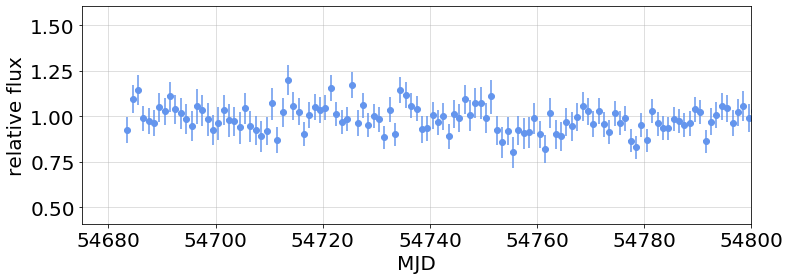

In [ ]:
#collapse_hide
if lc is not None:
    plt.rc('font', size=20)
    fig = flux_plot(config, lc, fmt='o', xlim=(54675, 54800))

And forcing upper limits

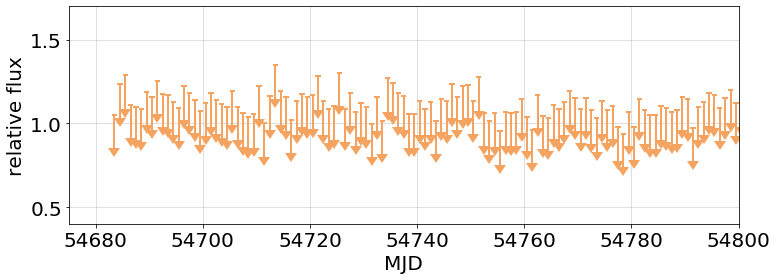

In [ ]:
#collapse_hide
if lc is not None:
    fig = flux_plot(config, lc, fmt='o', xlim=(54675, 54800), ts_min=1000)

In [ ]:
!date

Mon Dec 14 11:40:37 PST 2020


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_load_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 07_cells.ipynb.
Converted 09_poisson.ipynb.
Converted 10_loglike.ipynb.
Converted 11_lightcurve.ipynb.
Converted 12_instructions.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted Untitled.ipynb.
Converted index.ipynb.
Mon Dec 14 11:40:38 PST 2020
